In [86]:
import yfinance as yf
import datetime
from cvxopt import solvers, matrix, log, spdiag
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math


# Fetch Data for portfolio

## Define stocks in portfolio

In [87]:
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'V', 'INTC', 'PG', 'CSCO']

## Define period for historical data

In [88]:
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

## Get historcial data

In [89]:
historical_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  10 of 10 completed


In [90]:
historical_data

,AAPL,AMZN,CSCO,GOOGL,INTC,JPM,MSFT,PG,TSLA,V
Date,,,,,,,,,,
2020-01-02,73.152664,94.900497,42.764030,68.433998,54.385216,124.254189,154.779510,111.796608,28.684000,185.897446
2020-01-03,72.441460,93.748497,42.066311,68.075996,53.723721,122.614487,152.852264,111.044716,29.534000,184.419006
2020-01-06,73.018684,95.143997,42.216461,69.890503,53.571762,122.516975,153.247330,111.198715,30.102667,184.020218
2020-01-07,72.675278,95.343002,41.942665,69.755501,52.677856,120.434128,151.850098,110.510231,31.270666,183.533844
2020-01-08,73.844337,94.598503,41.969162,70.251999,52.713615,121.373619,154.268799,110.981308,32.809334,186.675598
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,131.127060,85.250000,45.712193,89.230003,25.494946,126.698746,236.631805,148.841446,123.150002,204.208374
2022-12-27,129.307236,83.040001,45.760326,87.389999,25.348366,127.142731,234.877380,150.138535,109.099998,204.664719
2022-12-28,125.339417,81.820000,45.317455,86.019997,24.957489,127.837608,232.468719,148.197800,112.709999,203.374985


In [91]:
historical_data.to_csv('historical_data.csv')

<AxesSubplot:xlabel='Date'>

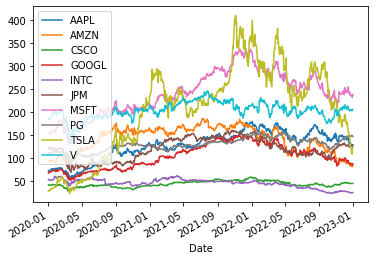

In [92]:
historical_data.plot()

## compute price ratio between days

In [93]:
price_ratio = historical_data / historical_data.shift(1)
price_ratio.to_csv('price_ratio.csv')
price_ratio

,AAPL,AMZN,CSCO,GOOGL,INTC,JPM,MSFT,PG,TSLA,V
Date,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.990278,0.987861,0.983684,0.994769,0.987837,0.986804,0.987548,0.993274,1.029633,0.992047
2020-01-06,1.007968,1.014886,1.003569,1.026654,0.997171,0.999205,1.002585,1.001387,1.019255,0.997838
2020-01-07,0.995297,1.002092,0.993514,0.998068,0.983314,0.983000,0.990883,0.993809,1.038801,0.997357
2020-01-08,1.016086,0.992191,1.000632,1.007118,1.000679,1.007801,1.015928,1.004263,1.049205,1.017118
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.997202,1.017425,1.003381,1.016750,1.004621,1.004745,1.002267,1.002825,0.982449,1.003755
2022-12-27,0.986122,0.974076,1.001053,0.979379,0.994251,1.003504,0.992586,1.008715,0.885911,1.002235
2022-12-28,0.969315,0.985308,0.990322,0.984323,0.984580,1.005465,0.989745,0.987074,1.033089,0.993698


## Find the greatest norm of price ratio vector
(to determine the Lipschitz parameters)

In [94]:
max_norm_2 = 0
max_norm_inf = 0

for index, row in price_ratio.iterrows():
    vector = np.array(row)
    
    norm_2 = np.linalg.norm(vector) / np.min(vector)
    norm_inf = np.max(vector) / np.min(vector)

    max_norm_2 = max(max_norm_2, norm_2)        # G parameter for Linearized FTL
    max_norm_inf = max(max_norm_inf, norm_inf)  # G_int parameter for Exponentiated gradient descent

# Helper functions and constants

In [95]:
# number of stocks
n=len(stocks)

# Lipschitz parameters
G = math.ceil(max_norm_2) 
G_inf = math.ceil(max_norm_inf) 

# diameter of a simplex upper bounded by sqrt(2)
D = 1.414213562

# initial distribution
x0 = np.array(n * [1/n])

# get cost vectors from price ratio
ratio_vectors = price_ratio.values

# initial price
initial_price = price_ratio.values

# initial wealth
wealth_0 = 1



def euclidean_projection(y):
    n = len(y)

    # Define the objective function: minimize (1/2) * ||x - y||^2
    P = matrix(np.identity(n))
    q = matrix(-y)

    # Define the equality constraint: sum(x) = 1
    A = matrix(1.0, (1, n))
    b = matrix(1.0)

    # Define the inequality constraints: x >= 0
    G = matrix(-np.identity(n))
    h = matrix(np.zeros(n))

    # Solve the convex optimization problem
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)

    # Extract the solution vector x
    x = np.array(solution['x']).flatten()

    return x

def matrix_projection(A, y):
    P = matrix(A * 2)
    q = matrix(-2 * A.T @ y)

    # Define the equality constraint: sum(x) = 1
    A = matrix(1.0, (1, n))
    b = matrix(1.0)

    # Define the inequality constraints: x >= 0
    G = matrix(-np.identity(n))
    h = matrix(np.zeros(n))

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)

    return np.array(sol['x']).flatten()

def f(r, x):
    return -np.log(r @ x)

def gradient(rt ,x):
    return -rt / (x @ rt)

# Algorithms

In [96]:
# a parent class for all algorithms
class Methods:
    def __init__(self):
        self.wealths = []
    def __str__(self):
        pass

    def solve(self):
        pass

    def plot_wealths(self):
        plt.plot(*zip(*enumerate(self.wealths)), label=self.__str__())
        plt.xlabel('Time')
        plt.ylabel('Wealth')
        plt.title('Wealth vs time graph')
        plt.legend()


## Linearized FTL

In [97]:
class LinearizedFTL(Methods):

    def __str__(self):
        return "Linearized FTL"

    def solve(self):
        x = x0
        wealth = wealth_0

        gradient_sum = 0
        for t in range(1, len(ratio_vectors)):
            rt = ratio_vectors[t]
            wealth *= (x @ rt)
            self.wealths.append(wealth)

            gradient_sum = gradient_sum + gradient(rt, x)

            min_idx = np.argmin(gradient_sum)
            x1 = np.zeros(n)
            x1[min_idx] = 1

            x = x1

## Exponentiated Gradient Descent

In [98]:
class ExponentiatedGD(Methods):

    def __str__(self):
        return "Exponentiated GD"

    def solve(self):
        x = x0
        y = np.ones(n)
        wealth = wealth_0

        for t in range(1, len(ratio_vectors)):
            rt = ratio_vectors[t]
            wealth *= (x @ rt)
            self.wealths.append(wealth)

            stepsize = np.sqrt(np.log(n) / (2*len(ratio_vectors)*G_inf**2))
            y1 = np.zeros(n)
            neg_gradient =  -gradient(rt,x)

            for i in range(n):
                y1[i] = y[i] * np.exp(stepsize * neg_gradient[i])

            x1 = y1 / np.linalg.norm(y1, 1)

            x = x1

## Online Gradient Descent

In [99]:
class OnlineGradientDescent(Methods):
    D_G = D/G  # D/G ratio for step size

    def __str__(self):
        return "Online Gradient Descent"

    def solve(self):
        x = x0
        wealth = wealth_0

        for t in range(1, len(ratio_vectors)):
            rt = ratio_vectors[t]
            wealth *= (x @ rt)
            self.wealths.append(wealth)

            stepsize = self.D_G / np.sqrt(t)
           
            y1 = x - stepsize * gradient(rt, x)
            x1 = euclidean_projection(y1)

            x = x1

# Adaptive Online Gradient Descent

In [100]:
class AdaptiveOnlineGradientDescent(Methods):
    def __str__(self):
        return "Adaptive Online Gradient Descent"

    def solve(self):
        x = x0
        wealth = wealth_0
        gradient_norm_squared_sum = 0
        
        for t in range(1, len(ratio_vectors)):
            rt = ratio_vectors[t]
            wealth *= (x @ rt)
            self.wealths.append(wealth)
            
            gradient_norm_squared_sum += rt @ rt
            stepsize = np.sqrt(2) * D / (2 * np.sqrt(gradient_norm_squared_sum))
           
            y1 = x - stepsize * gradient(rt, x)
            x1 = euclidean_projection(y1)

            x = x1

## Online Newton step

In [101]:
class OnlineNewtonStep(Methods):

    def __str__(self):
        return "Online Newton step"

    def solve(self):
        x = x0
        wealth = wealth_0

        gamma = 1/(2*G*D)
        epsilon = 1 / (gamma**2 * D**2)

        A = epsilon * np.eye(n)

        for t in range(1, len(ratio_vectors)):
            rt = ratio_vectors[t]
            wealth *= (x @ rt)
            self.wealths.append(wealth)
            
            gradient_x = gradient(rt, x)
            # rank-1 udpate
            A = A + np.outer(gradient_x, gradient_x)

            # newton step and project
            y = x- 1/gamma * np.linalg.inv(A) @ gradient_x
            x1 = matrix_projection(A, y)

            x = x1

# Run experiments

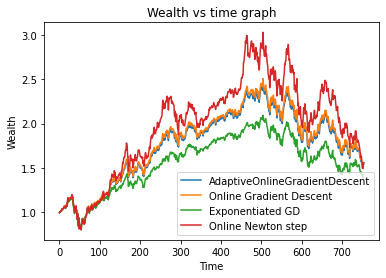

In [102]:
ogd = OnlineGradientDescent()
lftl = LinearizedFTL()
egd = ExponentiatedGD()
ons = OnlineNewtonStep()
aogd = AdaptiveOnlineGradientDescent()

ogd.solve()
lftl.solve()
egd.solve()
ons.solve()
aogd.solve()

aogd.plot_wealths()
ogd.plot_wealths()
egd.plot_wealths()
ons.plot_wealths()
# lftl.plot_wealths()

plt.show()